# Курсовая работа по теме «Машинное обучение в задачах кредитного скоринга»

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,\
roc_curve, precision_recall_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.model_selection import KFold, cross_val_score
from yellowbrick.model_selection import LearningCurve
import warnings
warnings.filterwarnings('ignore')

### 1. Выбрать набор данных для анализа в соответствии с выбранной темой курсовой работы. Описать этот набор и решаемую задачу.

В данной работе будет использован датасет HMEQ (The Home Equity dataset). Набор данных о собственном капитале содержит информацию о параметрах и результатах кредитования по 5 960 кредитам на приобретение жилья. 

Целевой показатель (__BAD__) - это бинарная переменная, равная 1, если клиент не выполнил обязательства по кредиту или имел серьезные просрочки, и 0 - в случае своевременного погашения.\
Для каждого заемщика было введено 12 входных переменных:
- __LOAN__ - сумма кредита;
- __MORTDUE__ - сумма задолженности заемщика по ипотеке;
- __VALUE__ - оценочная стоимость объекта недвижимости;
- __REASON__ - цель кредита;
- __JOB__ - вид трудовой деятельности заемщика;
- __YOJ__ - число лет на текущей работе;
- __DEROG__ - количество уничижительных замечаний в кредитном отчете заемщика;
- __DELINQ__ - количество раз, когда заемщик задерживал платеж;
- __CLAGE__ - срок самой старой кредитной линии в месяцах;
- __NINQ__ - количество кредитных линий, открытых заемщиком за последние шесть месяцев;
- __CLNO__ - общее количество кредитных линий, имеющихся у заемщика;
- __DEBTINC__ - соотношение долга заемщика к доходу, которое рассчитывается путем деления общей суммы ежемесячных платежей заемщика по долгу на его ежемесячный доход.

__Бизнес-задача:__ Предсказание невыполнения заемщиком кредитных обязательств.

__Задача машинного обучения:__ Бинарная классификация.

__Ссылка на датасет:__ https://www.kaggle.com/datasets/ajay1735/hmeq-data

### 2. Провести предварительный анализ и очистку данных. Этот этап включает в себя вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной, вывод нескольких точек данных для иллюстрации структуры данных.

#### 2.1. Первичный анализ данных

Загрузим датасет:

In [2]:
df = pd.read_csv('hmeq.csv')

In [3]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
print(f'Количество строк: {df.shape[0]}\nКоличество столбцов: {df.shape[1]}')

Количество строк: 5960
Количество столбцов: 13


In [5]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Заметим, что признаки REASON и JOB являются категориальными, остальные — числовыми.

Выведем основую статистическую информацию о числовых столбцах:

In [7]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


#### 2.2. Предобработка данных

Проверим данные на наличие дубликатов:

In [8]:
df.duplicated().sum()

0

Дубликаты не найдены.

Проверим наличие пропущенных значений:

In [9]:
df.isna().sum().sort_values(ascending=False)

DEBTINC    1267
DEROG       708
DELINQ      580
MORTDUE     518
YOJ         515
NINQ        510
CLAGE       308
JOB         279
REASON      252
CLNO        222
VALUE       112
BAD           0
LOAN          0
dtype: int64

Пропущенные значения в данных могут существенно искажать результаты работы, поэтому пропуски нужно обработать.

Выведем уникальные значения категориальных переменных:

In [10]:
for col in df.describe(include='object').columns:
    print(col)
    print(df[col].unique())

REASON
['HomeImp' nan 'DebtCon']
JOB
['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']


Уникальные значения столбца REASON: 'HomeImp' - улучшение жилищных условий, 'DebtCon' - консолидация долга.\
Значения признака JOB: 'Office' - офисная работа, 'Sales' - работа в продажах, 'Mgr' - управляющая должность, 'Self' - самозанятый, 'Other' - другой вариант.

Заполним пропуски в столбцах REASON и JOB значением 'Other':

In [11]:
df['REASON'].fillna(value='Other', inplace=True)
df['JOB'].fillna(value='Other', inplace=True)

Для признаков DEROG (количество уничижительных замечаний в кредитном отчете заемщика) и DELINQ (количество раз, когда заемщик задерживал платеж) заменим пропуски нулевыми значениями:

In [12]:
df['DEROG'].fillna(value=0, inplace=True)
df['DELINQ'].fillna(value=0, inplace=True)

Для остальных числовых признаков заменим пропуски средним значением по каждому признаку:

In [13]:
df.fillna(value=df.mean(), inplace=True)

In [14]:
df.isna().sum().sort_values(ascending=False)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

Все пропущенные значения заполнены.

### 3. При необходимости, преобразовать атрибуты исходного датасета в числовые признаки. Этот этап сильно зависит от типа исследуемых данных и может включать в себя векторизацию текста, извлечение признаков их аудио и видео данных, преобразование изображений в плоский численный массив и другие преобразования.

Признаки REASON и JOB имеют тип object, т.е. являются категориальными переменными. Для преобразования этих переменных в числовые используем Label Encoding: каждой категории присвоим уникальное целое число. Для этого понадобится метод factorize библиотеки pandas:

In [15]:
df['REASON'] = pd.factorize(df['REASON'])[0]
df['JOB'] = pd.factorize(df['JOB'])[0]

df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0000,39025.000000,0,0,10.500000,0.0,0.0,94.366667,1.000000,9.000000,33.779915
1,1,1300,70053.0000,68400.000000,0,0,7.000000,0.0,2.0,121.833333,0.000000,14.000000,33.779915
2,1,1500,13500.0000,16700.000000,0,0,4.000000,0.0,0.0,149.466667,1.000000,10.000000,33.779915
3,1,1500,73760.8172,101776.048741,1,0,8.922268,0.0,0.0,179.766275,1.186055,21.296096,33.779915
4,0,1700,97800.0000,112000.000000,0,1,3.000000,0.0,0.0,93.333333,0.000000,14.000000,33.779915


### 4. Провести описательный анализ данных. Сделать выводы. Этот этап включает в себя определение шкалы измерения каждого признака, выявление аномальных значений, визуализацию распределения каждого признака, при необходимости - проверка на нормальность, построение кореллограмм и совместных распределений каждого признака с целевой переменной, выявление коррелированных признаков и признаков, не несущих информации для данной задачи.

#### 4.1. Выявление аномальных значений

Построим ящичковые диаграммы для каждого признака:

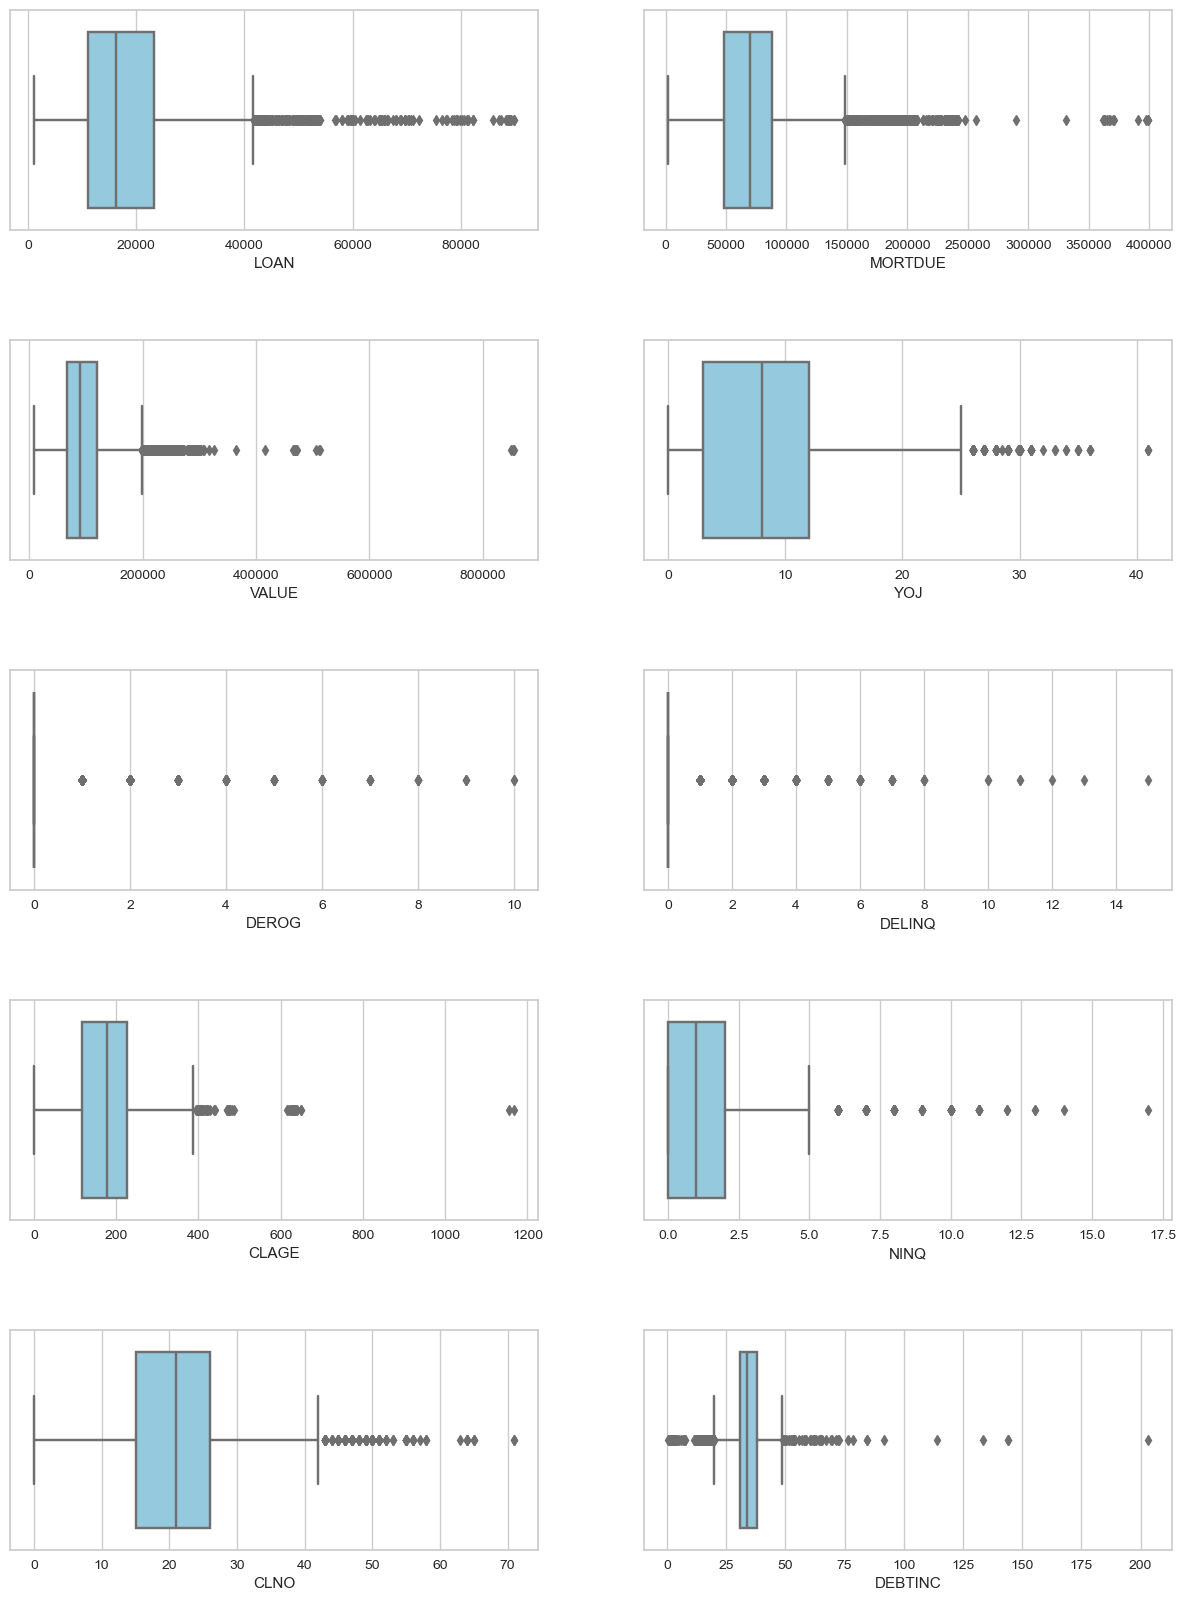

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
for i, ax in zip(df[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',\
                     'NINQ', 'CLNO', 'DEBTINC']].columns, axes.flat):
    sns.boxplot(data=df, x=i, ax=ax, color='skyblue')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Можно заметить большое количество выбросов.

#### 4.2. Визуализация распределения признаков

Построим гистограммы распределения для каждого признака:

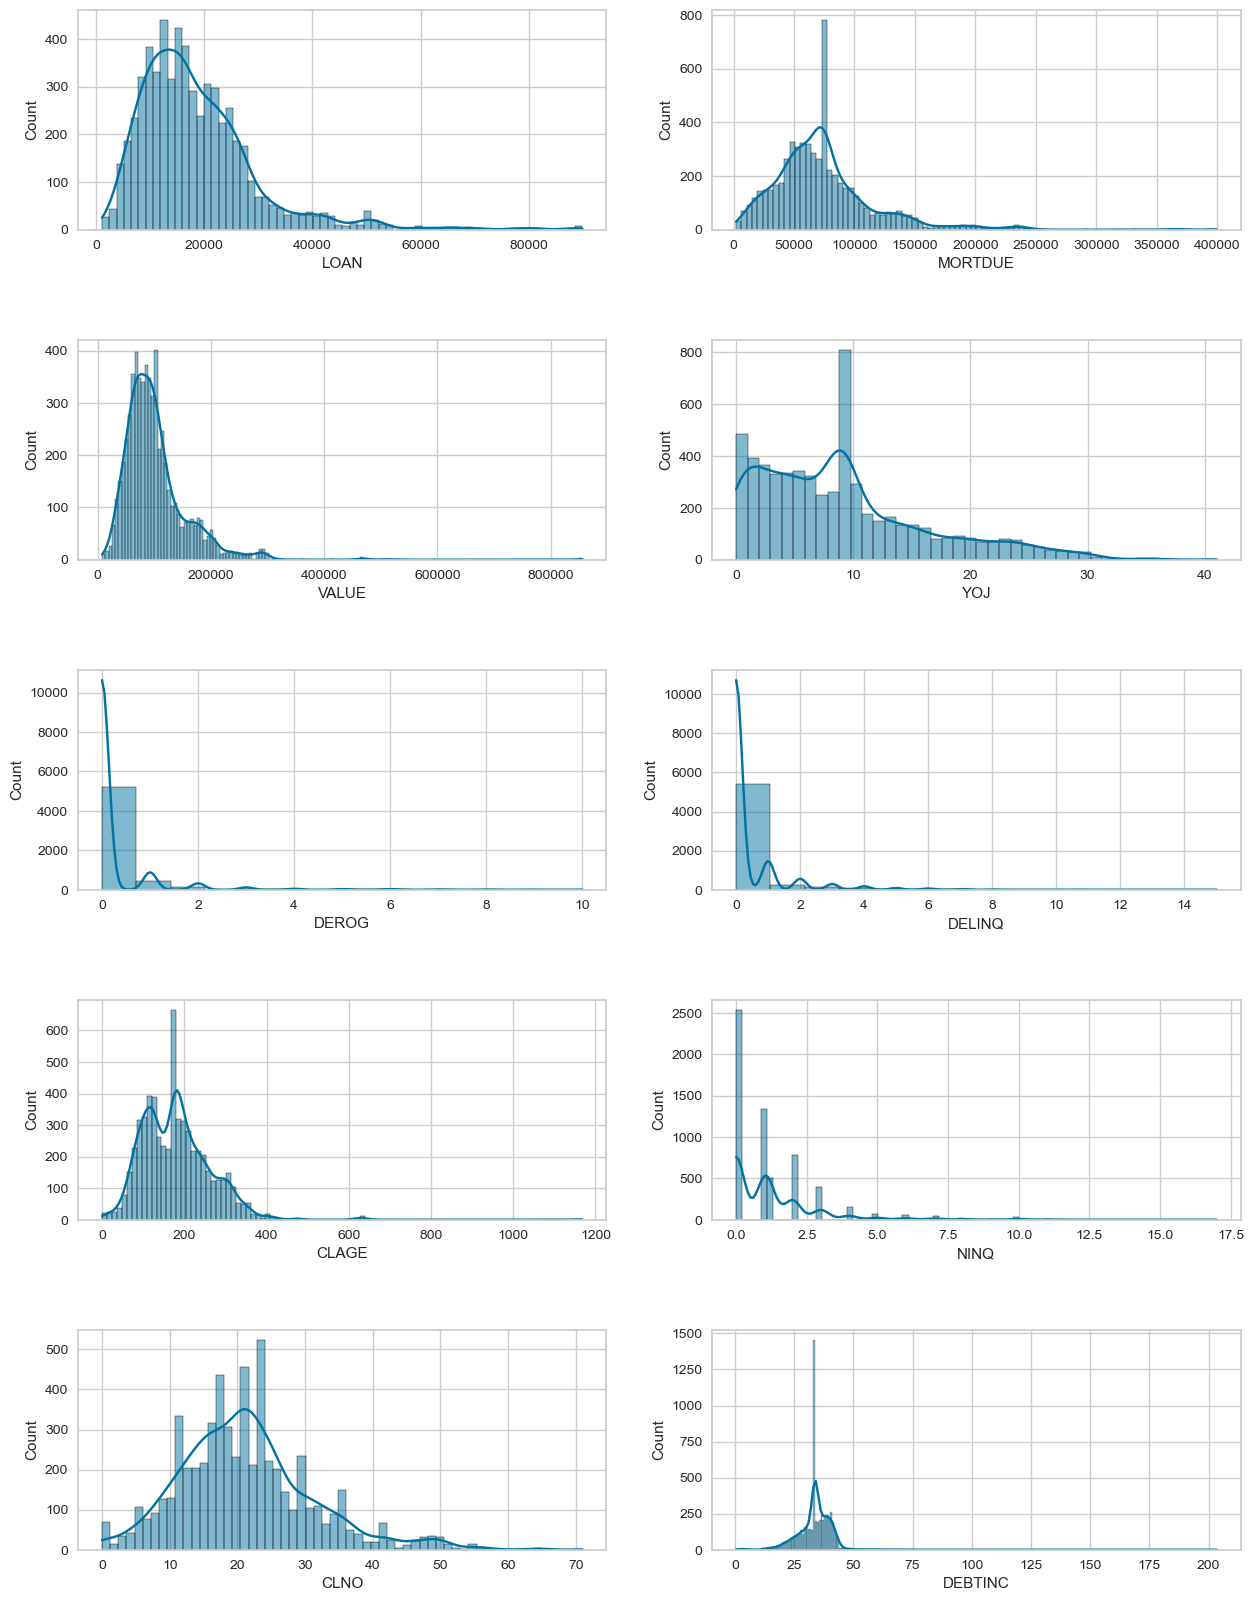

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
for i, ax in zip(df[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',\
                     'NINQ', 'CLNO', 'DEBTINC']].columns, axes.flat):
    sns.histplot(data=df, x=i, ax=ax, kde=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Некоторые признаки имеют асимметричное (скошенное) распределение.

Проверим целевой признак на сбалансированность:

In [18]:
print(f'Количество значений "0": {df["BAD"].value_counts()[0]}\nКоличество значений "1": {df["BAD"].value_counts()[1]}')

Количество значений "0": 4771
Количество значений "1": 1189


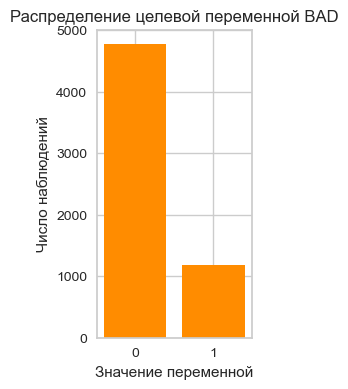

In [19]:
fig = plt.figure(figsize=(2, 4))
plt.bar(['0', '1'], df['BAD'].value_counts(), color='darkorange')
plt.xlabel('Значение переменной')
plt.ylabel('Число наблюдений')
plt.title('Распределение целевой переменной BAD')
plt.show()

Наблюдается дисбаланс целевого признака: около 80% значений нулевые, оставшиеся 20% равны 1.

Несбалансированность данных необходимо устранить по нескольким причинам. Во-первых, это ведет к снижению способности моделей обнаружения меньшего класса. Во-вторых, значения классических метрик точности при несбалансированных данных могут вводить в забуждение. Результатом становятся ошибки предсказания, когда модель ложно предсказывает меньший класс.

#### 4.3. Проверка на нормальность

Построим график нормальной вероятности  (normal probability plot) для каждого признака. Этот график показывает соотношение отсортированных по возрастанию данных и соответствующих им квантилей нормального распределения.

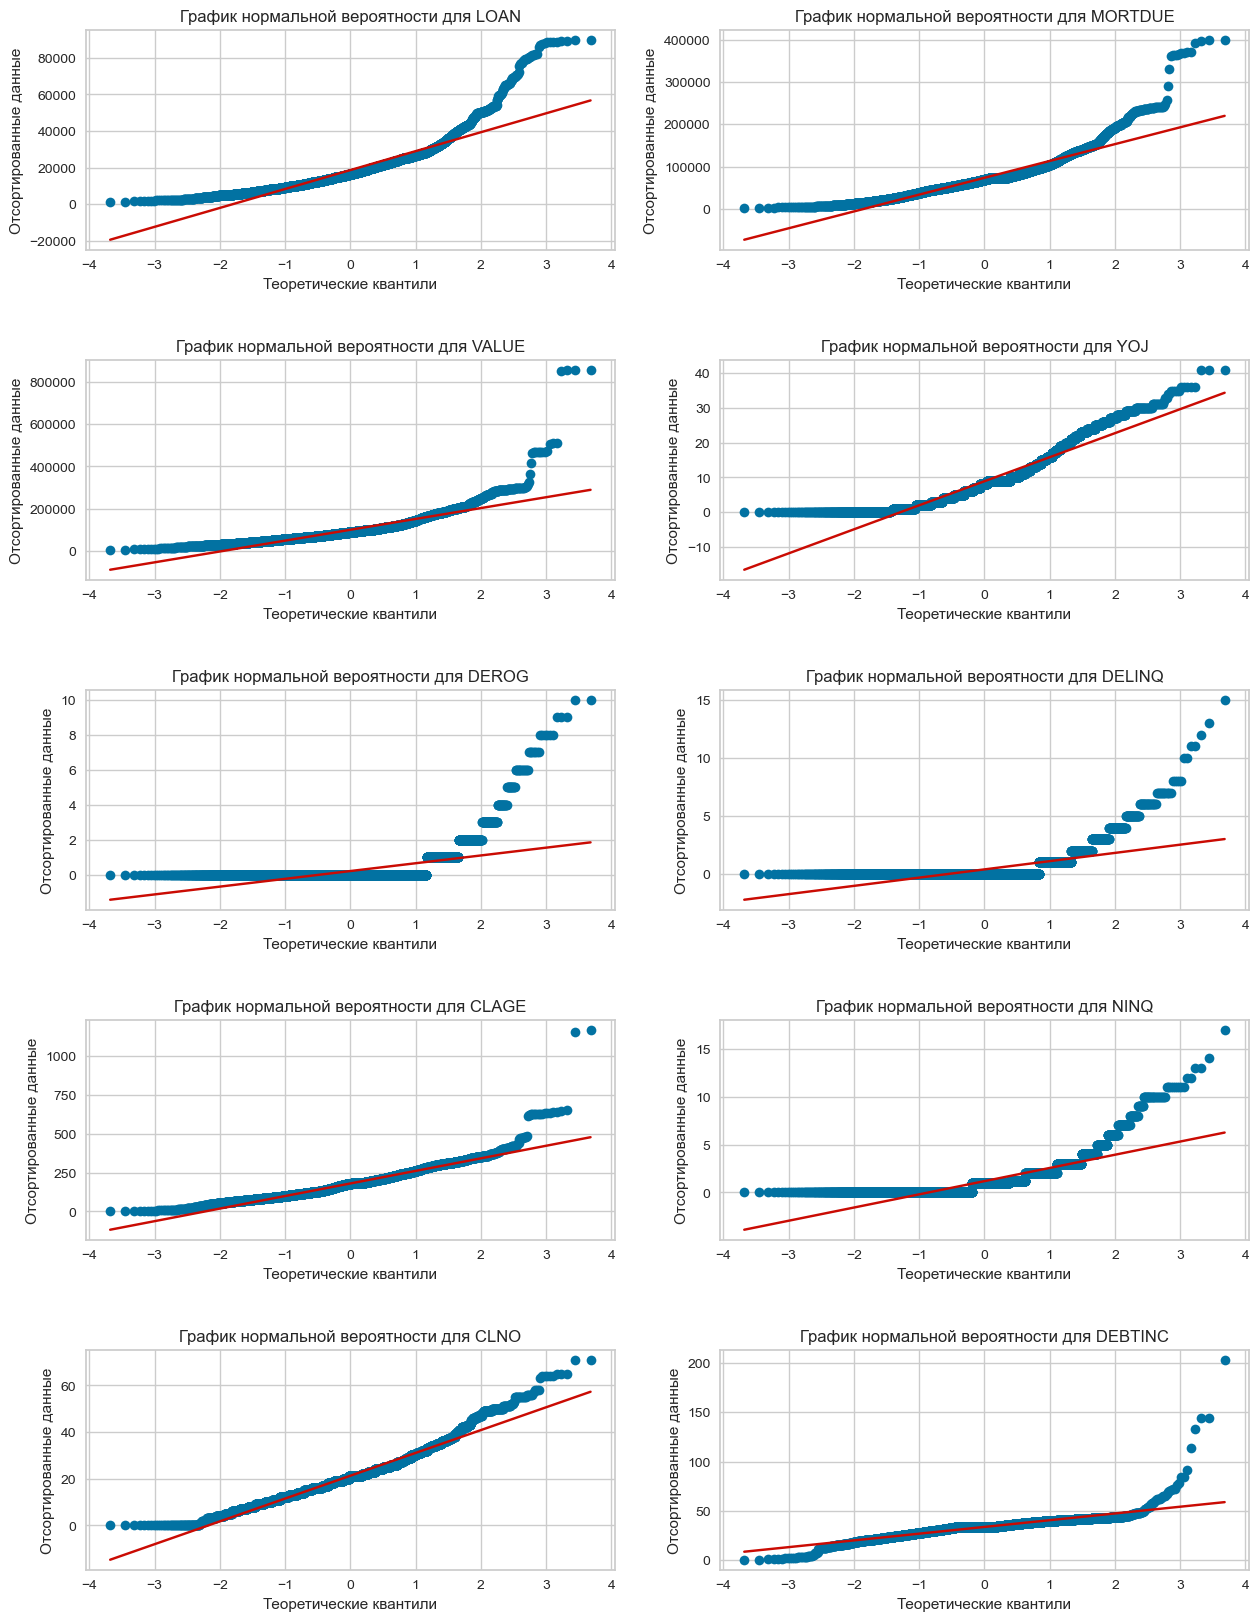

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
for i, ax in zip(df[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',\
                     'NINQ', 'CLNO', 'DEBTINC']].columns, axes.flat):
    probplot(df[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',\
                     'NINQ', 'CLNO', 'DEBTINC']][i], dist='norm', plot=ax)
    ax.set_title(f'График нормальной вероятности для {i}')
    ax.set_xlabel('Теоретические квантили')
    ax.set_ylabel('Отсортированные данные')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Точки исходных данных не лежат на одной прямой, наблюдаются отклонения. Следовательно, нельзя сделать вывод о нормальности распределения признаков.

#### 4.4. Выявление коррелированных признаков

Построим таблицу коэффициентов корреляции Пирсона:

In [21]:
df.corr()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
BAD,1.000000,-0.075099,-0.046034,-0.028852,-0.036695,-0.006331,-0.058314,0.269921,0.346503,-0.165113,0.168851,-0.004067,0.124324
LOAN,-0.075099,1.000000,0.216100,0.331862,0.163132,0.096597,0.100664,0.006996,-0.028869,0.086874,0.043160,0.071804,0.074823
MORTDUE,-0.046034,0.216100,1.000000,0.779787,0.027363,0.325992,-0.082856,-0.046476,0.000542,0.130757,0.029480,0.305288,0.128326
VALUE,-0.028852,0.331862,0.779787,1.000000,0.005553,0.341413,0.007382,-0.040727,-0.003615,0.167938,-0.004216,0.264037,0.115796
REASON,-0.036695,0.163132,0.027363,0.005553,1.000000,-0.020623,-0.050095,0.006269,-0.006913,-0.059785,0.121562,0.114794,0.056507
JOB,-0.006331,0.096597,0.325992,0.341413,-0.020623,1.000000,-0.034673,-0.018989,0.040866,0.087829,-0.028189,0.211687,-0.001824
YOJ,-0.058314,0.100664,-0.082856,0.007382,-0.050095,-0.034673,1.000000,-0.056245,0.046648,0.190937,-0.067898,0.024023,-0.047642
DEROG,0.269921,0.006996,-0.046476,-0.040727,0.006269,-0.018989,-0.056245,1.000000,0.171286,-0.080144,0.146700,0.050727,0.010744
DELINQ,0.346503,-0.028869,0.000542,-0.003615,-0.006913,0.040866,0.046648,0.171286,1.000000,0.024874,0.057212,0.159378,0.035353
CLAGE,-0.165113,0.086874,0.130757,0.167938,-0.059785,0.087829,0.190937,-0.080144,0.024874,1.000000,-0.110091,0.231595,-0.038052


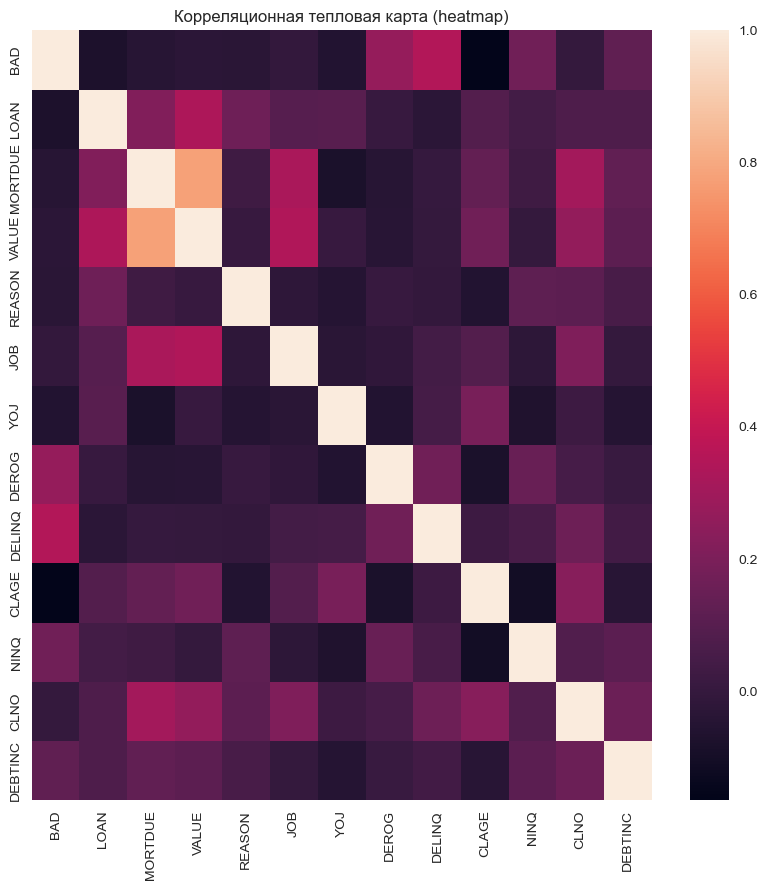

In [22]:
fig = plt.figure(figsize = (10,10))
plt.title('Корреляционная тепловая карта (heatmap)')
hm = sns.heatmap(df.corr())
plt.show()

Можно заметить высокую степень корреляции между признаками VALUE и MORTDUE:

In [23]:
df['VALUE'].corr(df['MORTDUE'])

0.7797869437012027

Ввиду этого удалим один из столбцов:

In [24]:
df.drop('VALUE', axis=1, inplace=True)

#### 4.5. Устранение несбалансированности данных

Обозначим целевую переменную за y0, а остальные признаки — за X0:

In [25]:
y0 = df['BAD']
X0 = df.drop(columns=['BAD'])

Для решения проблемы несбалансированности данных воспользуемся методом генерации синтетических данных (Synthetic Minority Over-sampling Technique). Метод генерирует новые синтетические примеры меньшего класса, пока количественный баланс не будет достигнут.

In [26]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X0, y0)

In [27]:
print(f'Количество наблюдений после генерации синтетических данных: {len(y)}')

Количество наблюдений после генерации синтетических данных: 9542


### 5. Применить при необходимости к данным методы обучения без учителя: кластеризацию, понижение размерности и поиск аномалий. Сделать выводы.

Используем метод главных компонент (PCA) — наиболее популярный метод понижения размерности.

Для определения оптимального числа компонент построим график объясненной дисперсии:

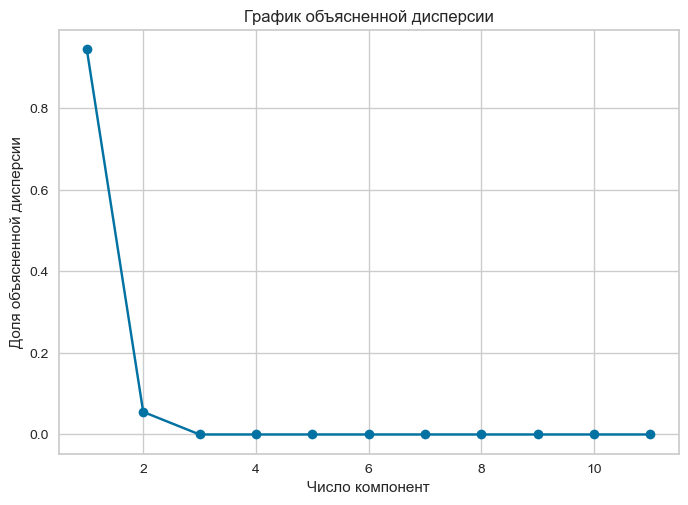

In [28]:
pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Число компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.title('График объясненной дисперсии')
plt.show()

Доля объясненной дисперсии перестает снижаться в точке 3. Следовательно, в качестве оптимального числа компонент выберем 3 (по «методу локтя»).

Теперь используем PCA для уменьшения размерности:

In [29]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

### 6. Разделить набор данных на обучающую и тестовую выборки. Обосновать количественные характеристики и метод разделения (временной, случайный, последовательный).

Разделим набор данных на обучающую и тестовую выборки случайным образом. Преимущество случайного разделения состоит в том, что выборки получаются репрезентативными. В будущем это поможет избежать переобучения моделей.\
Деление выполним в пропорции 80:20 (чаще всего в машинном обучении на обучающую выборку отводится 70-80%, на тестовую — 20-30% соответственно).

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7. Обучить несколько моделей для решения выбранной задачи (для задач классификации - не менее 7 различных алгоритмов). Проанализировать результаты, сделать выводы.

#### 7.1. Логистическая регрессия

In [31]:
%%time
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

CPU times: total: 156 ms
Wall time: 78.1 ms


LogisticRegression()

In [32]:
y_pred_lr = logistic_regression.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)

print(f'Accuracy score: {acc_lr.round(4)}')
print(f'F1 score: {f1_lr.round(4)}')
print(f'Precision score: {prec_lr.round(4)}')
print(f'Recall score: {rec_lr.round(4)}')

Accuracy score: 0.6579
F1 score: 0.6506
Precision score: 0.6711
Recall score: 0.6314


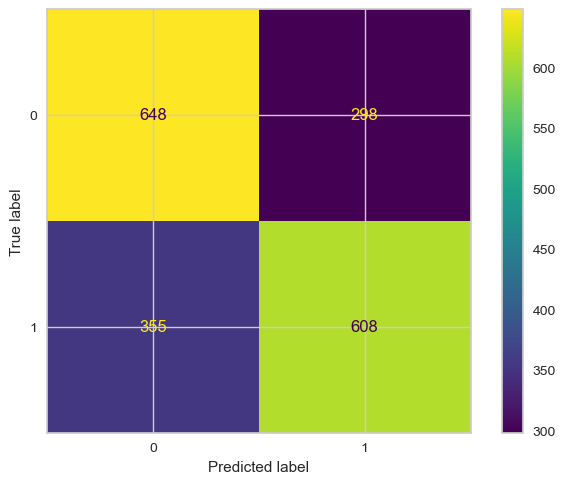

In [33]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=logistic_regression.classes_)
disp.plot();

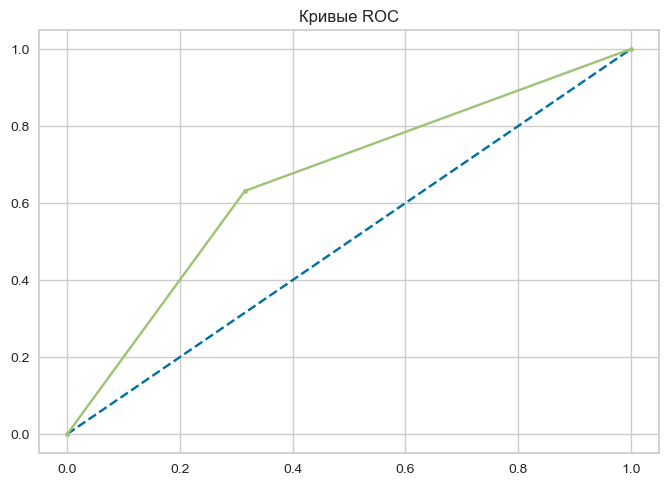

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [35]:
# площадь под кривыми ROC-AUC
roc_lr = roc_auc_score(y_test, y_pred_lr); roc_lr.round(4)

0.6582

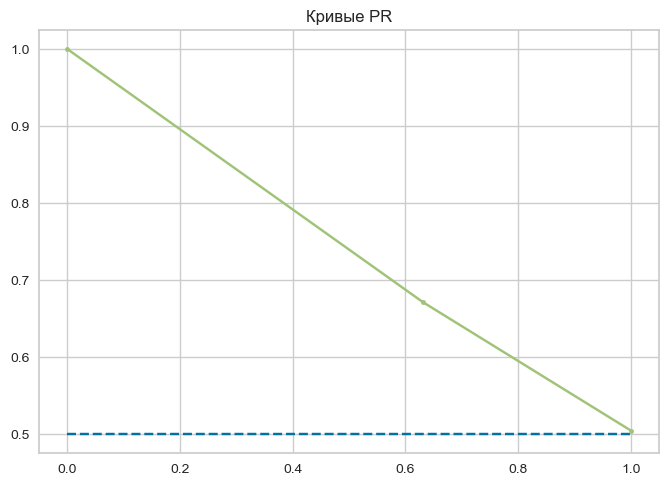

In [36]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [37]:
# площадь под кривыми PR-AUC
pr_lr = auc(recall, precision); pr_lr.round(4)

0.7442

#### 7.2. Метод K-ближайших соседей

In [38]:
%%time
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 31.3 ms


KNeighborsClassifier(n_neighbors=3)

In [39]:
y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy score: {acc_knn.round(4)}')
print(f'F1 score: {f1_knn.round(4)}')
print(f'Precision score: {prec_knn.round(4)}')
print(f'Recall score: {rec_knn.round(4)}')

Accuracy score: 0.7454
F1 score: 0.7601
Precision score: 0.7244
Recall score: 0.7996


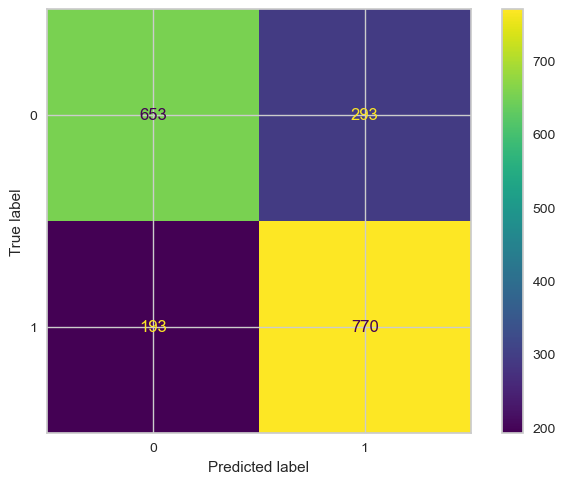

In [40]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot();

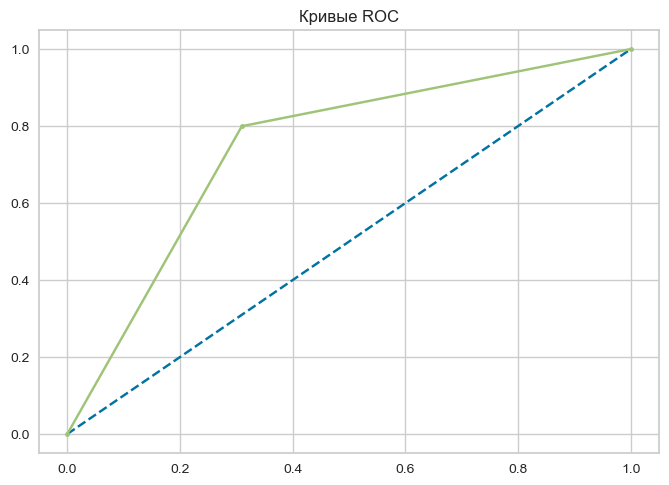

In [41]:
fpr, tpr, _ = roc_curve(y_test, y_pred_knn)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [42]:
# площадь под кривыми ROC-AUC
roc_knn = roc_auc_score(y_test, y_pred_knn); roc_knn.round(4)

0.7449

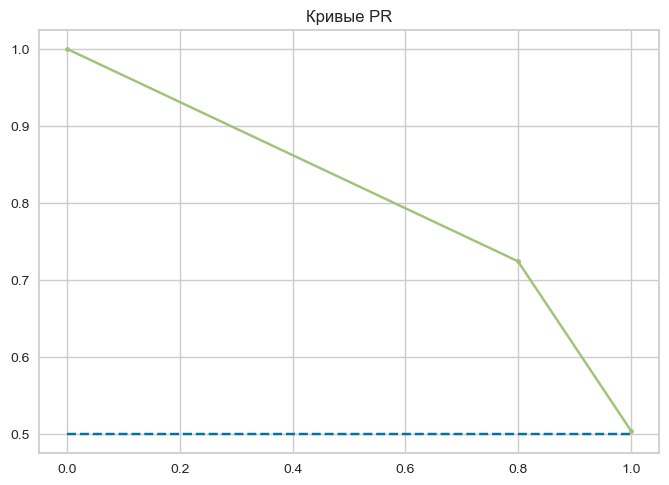

In [43]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_knn)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [44]:
# площадь под кривыми PR-AUC
pr_knn = auc(recall, precision); pr_knn.round(4)

0.8125

#### 7.3. Метод опорных векторов

##### a) с линейным ядром

In [45]:
%%time
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train, y_train)

CPU times: total: 29min 53s
Wall time: 30min 10s


SVC(kernel='linear')

In [46]:
y_pred_lin = svm_lin.predict(X_test)

acc_lin = accuracy_score(y_test, y_pred_lin)
f1_lin = f1_score(y_test, y_pred_lin)
prec_lin = precision_score(y_test, y_pred_lin)
rec_lin = recall_score(y_test, y_pred_lin)

print(f'Accuracy score: {acc_lin.round(4)}')
print(f'F1 score: {f1_lin.round(4)}')
print(f'Precision score: {prec_lin.round(4)}')
print(f'Recall score: {rec_lin.round(4)}')

Accuracy score: 0.7077
F1 score: 0.6921
Precision score: 0.7385
Recall score: 0.6511


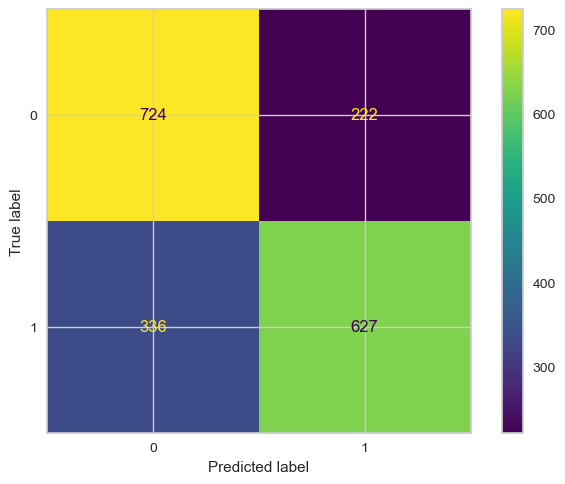

In [47]:
cm_lin = confusion_matrix(y_test, y_pred_lin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lin, display_labels=svm_lin.classes_)
disp.plot();

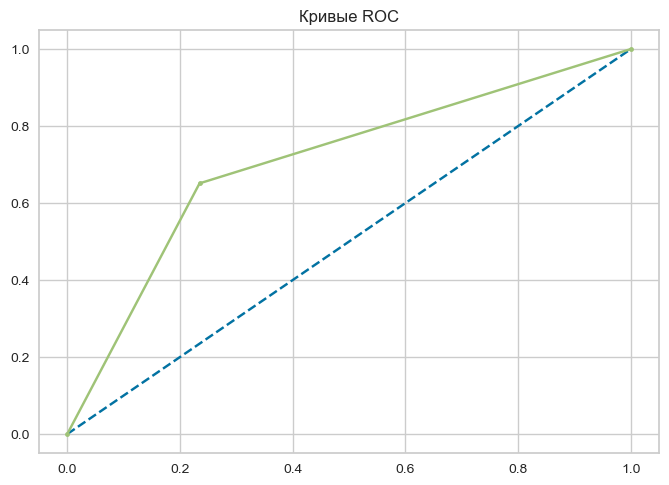

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_pred_lin)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [49]:
# площади под кривыми ROC - AUC
roc_lin = roc_auc_score(y_test, y_pred_lin); roc_lin.round(4)

0.7082

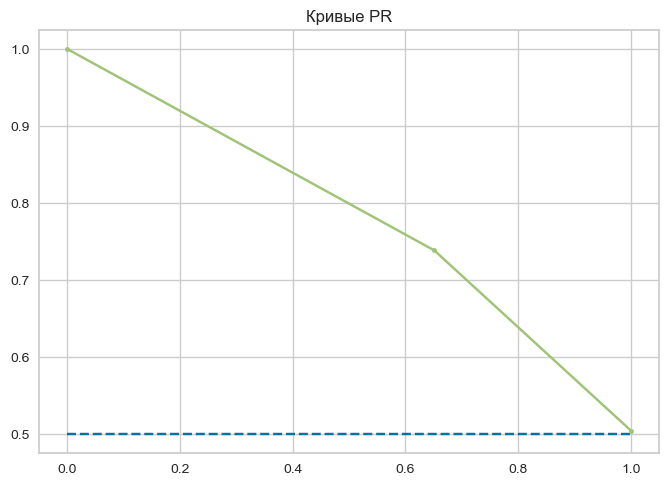

In [50]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_lin)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [51]:
# площадь под кривыми PR-AUC
pr_lin = auc(recall, precision); pr_lin.round(4)

0.7828

##### b) с ядром радиальной базисной функции

In [52]:
%%time
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

CPU times: total: 4.77 s
Wall time: 4.8 s


SVC()

In [53]:
y_pred_rbf = svm_rbf.predict(X_test)

acc_rbf = accuracy_score(y_test, y_pred_rbf)
f1_rbf = f1_score(y_test, y_pred_rbf)
prec_rbf = precision_score(y_test, y_pred_rbf)
rec_rbf = recall_score(y_test, y_pred_rbf)

print(f'Accuracy score: {acc_rbf.round(4)}')
print(f'F1 score: {f1_rbf.round(4)}')
print(f'Precision score: {prec_rbf.round(4)}')
print(f'Recall score: {rec_rbf.round(4)}')

Accuracy score: 0.5668
F1 score: 0.4795
Precision score: 0.6086
Recall score: 0.3956


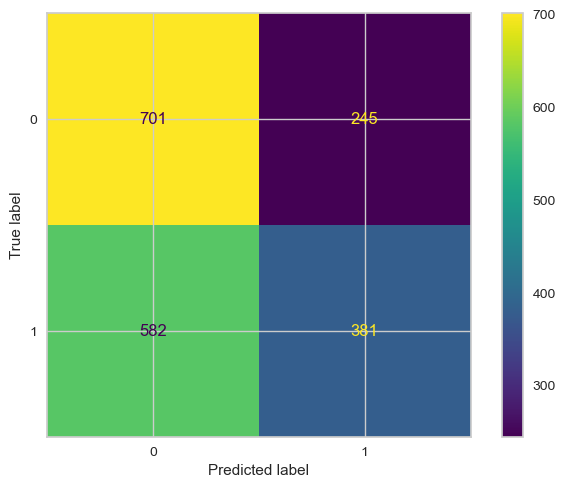

In [54]:
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=svm_rbf.classes_)
disp.plot();

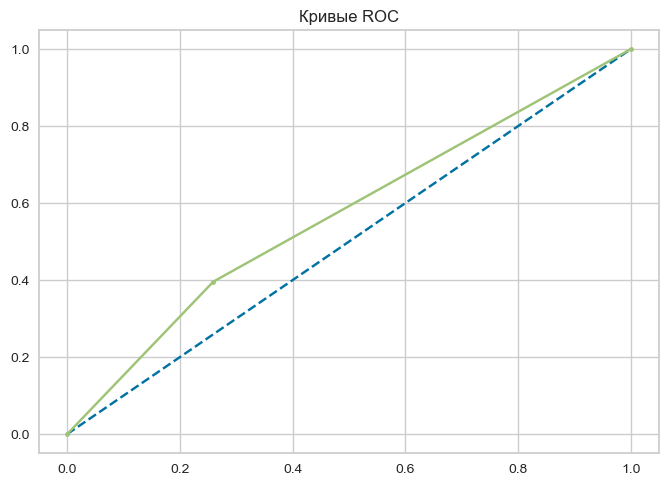

In [55]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rbf)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [56]:
# площадь под кривыми ROC-AUC
roc_rbf = roc_auc_score(y_test, y_pred_rbf); roc_rbf.round(4)

0.5683

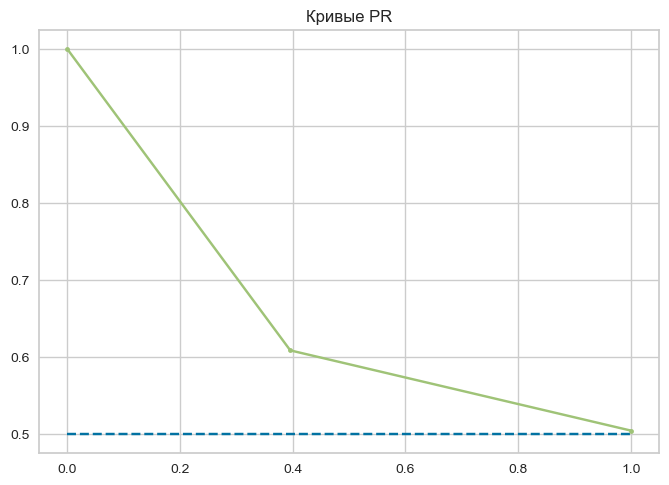

In [57]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_rbf)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [58]:
# площадь под кривыми PR-AUC
pr_rbf = auc(recall, precision); pr_rbf.round(4)

0.6546

##### c) с полиномиальным ядром

In [59]:
%%time
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train, y_train)

CPU times: total: 6.09 s
Wall time: 6.12 s


SVC(kernel='poly')

In [60]:
y_pred_poly = svm_poly.predict(X_test)

acc_poly = accuracy_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)
prec_poly = precision_score(y_test, y_pred_poly)
rec_poly = recall_score(y_test, y_pred_poly)

print(f'Accuracy score: {acc_poly.round(4)}')
print(f'F1 score: {f1_poly.round(4)}')
print(f'Precision score: {prec_poly.round(4)}')
print(f'Recall score: {rec_poly.round(4)}')

Accuracy score: 0.4955
F1 score: 0.6569
Precision score: 0.5
Recall score: 0.9574


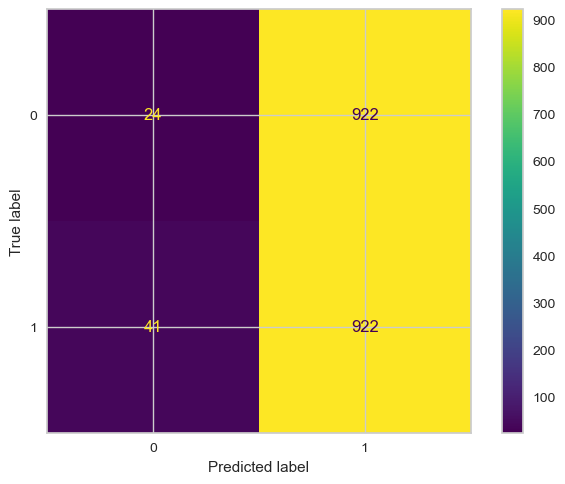

In [61]:
cm_poly = confusion_matrix(y_test, y_pred_poly)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_poly, display_labels=svm_poly.classes_)
disp.plot();

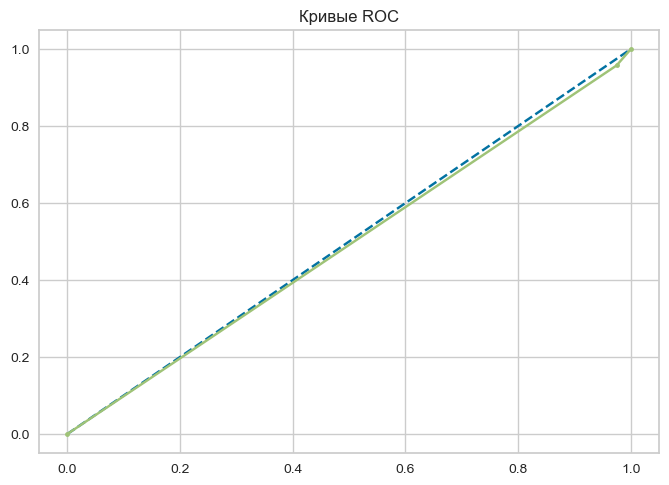

In [62]:
fpr, tpr, _ = roc_curve(y_test, y_pred_poly)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [63]:
# площадь под кривыми ROC-AUC
roc_poly = roc_auc_score(y_test, y_pred_poly); roc_poly.round(4)

0.4914

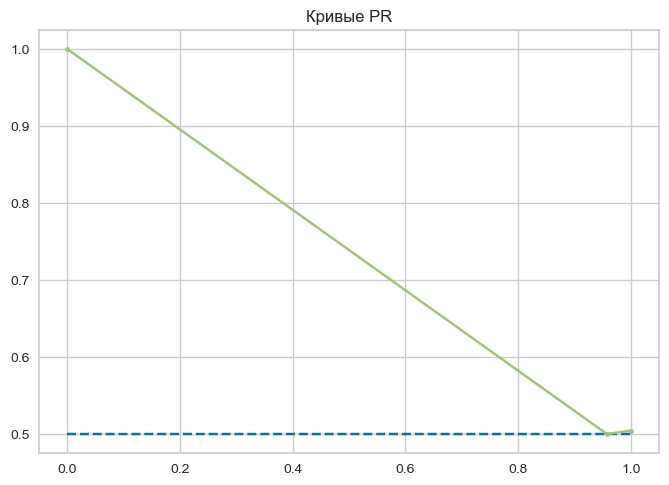

In [64]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_poly)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [65]:
# площадь под кривыми PR-AUC
pr_poly = auc(recall, precision); pr_poly.round(4)

0.7395

##### d) с сигмоидным ядром

In [66]:
%%time
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X_train, y_train)

CPU times: total: 3.16 s
Wall time: 3.18 s


SVC(kernel='sigmoid')

In [67]:
y_pred_sigmoid = svm_sigmoid.predict(X_test)

acc_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
f1_sigmoid = f1_score(y_test, y_pred_sigmoid)
prec_sigmoid = precision_score(y_test, y_pred_sigmoid)
rec_sigmoid = recall_score(y_test, y_pred_sigmoid)

print(f'Accuracy score: {acc_sigmoid.round(4)}')
print(f'F1 score: {f1_sigmoid.round(4)}')
print(f'Precision score: {prec_sigmoid.round(4)}')
print(f'Recall score: {rec_sigmoid.round(4)}')

Accuracy score: 0.5107
F1 score: 0.5016
Precision score: 0.5159
Recall score: 0.4881


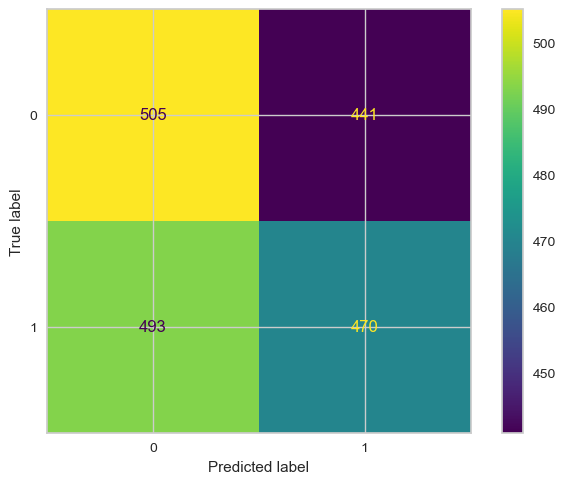

In [68]:
cm_sigmoid = confusion_matrix(y_test, y_pred_sigmoid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sigmoid, display_labels=svm_sigmoid.classes_)
disp.plot();

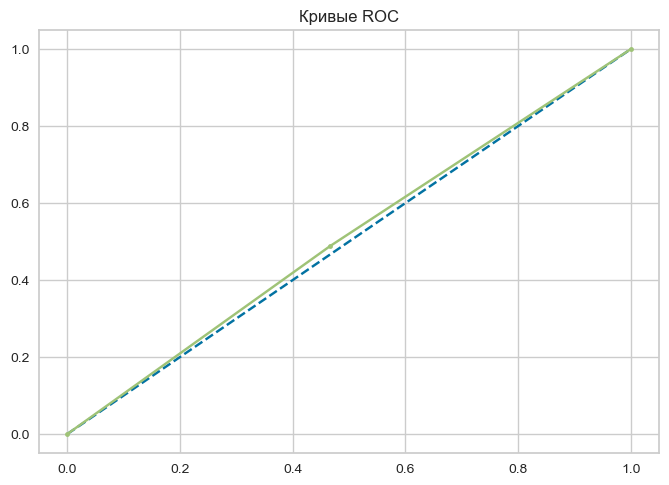

In [69]:
fpr, tpr, _ = roc_curve(y_test, y_pred_sigmoid)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [70]:
# площадь под кривыми ROC-AUC
roc_sigmoid = roc_auc_score(y_test, y_pred_sigmoid); roc_sigmoid.round(4)

0.5109

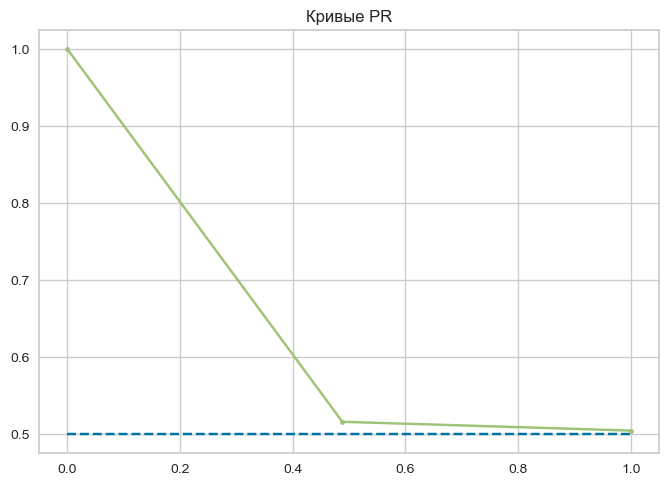

In [71]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_sigmoid)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [72]:
# площадь под кривыми PR-AUC
pr_sigmoid = auc(recall, precision); pr_sigmoid.round(4)

0.6311

#### 7.4. Наивный Байесовский классификатор

In [73]:
%%time
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 10 ms


GaussianNB()

In [74]:
y_pred_nb = gaussian_nb.predict(X_test)

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
prec_nb = precision_score(y_test, y_pred_nb)
rec_nb = recall_score(y_test, y_pred_nb)

print(f'Accuracy score: {acc_nb.round(4)}')
print(f'F1 score: {f1_nb.round(4)}')
print(f'Precision score: {prec_nb.round(4)}')
print(f'Recall score: {rec_nb.round(4)}')

Accuracy score: 0.6941
F1 score: 0.6168
Precision score: 0.8378
Recall score: 0.4881


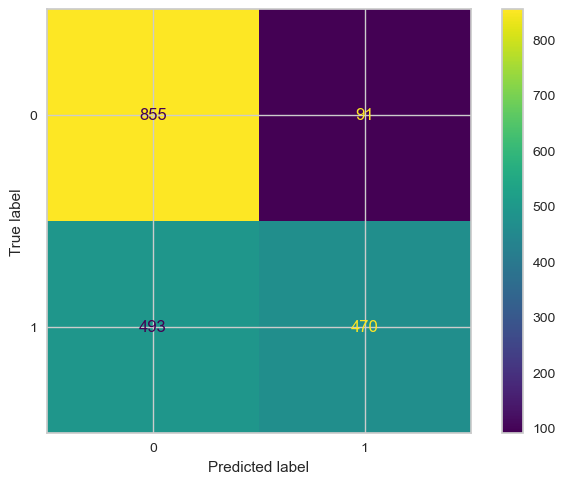

In [75]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=gaussian_nb.classes_)
disp.plot();

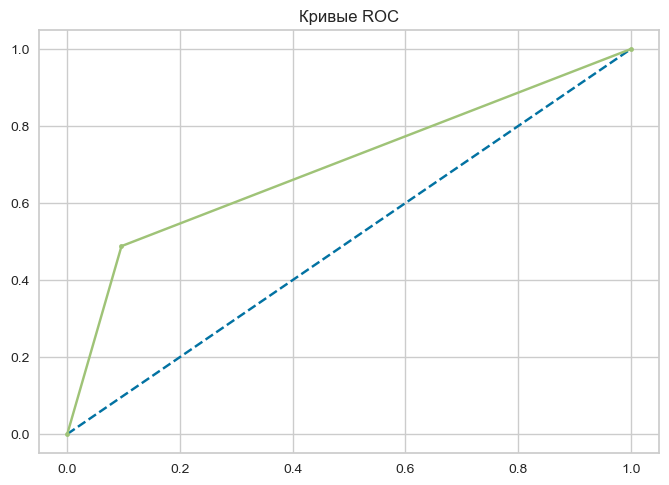

In [76]:
fpr, tpr, _ = roc_curve(y_test, y_pred_nb)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [77]:
# площадь под кривыми ROC-AUC
roc_nb = roc_auc_score(y_test, y_pred_nb); roc_nb.round(4)

0.6959

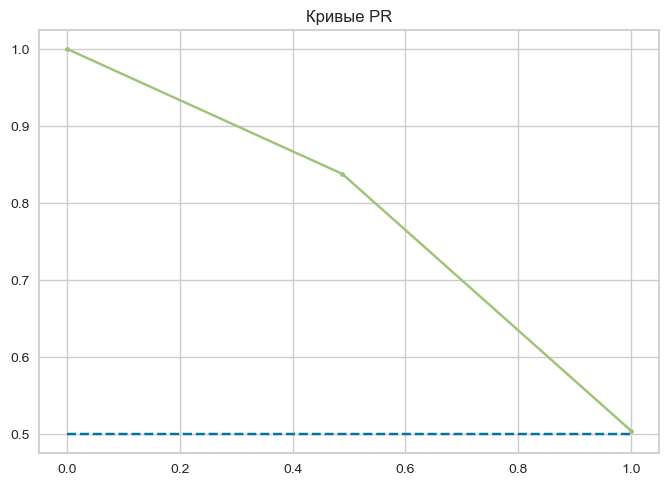

In [78]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_nb)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [79]:
# площадь под кривыми PR-AUC
pr_nb = auc(recall, precision); pr_nb.round(4)

0.792

#### 7.5. Дерево решений

In [80]:
%%time
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

CPU times: total: 109 ms
Wall time: 90.1 ms


DecisionTreeClassifier()

In [81]:
y_pred_dt = dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)

print(f'Accuracy score: {acc_dt.round(4)}')
print(f'F1 score: {f1_dt.round(4)}')
print(f'Precision score: {prec_dt.round(4)}')
print(f'Recall score: {rec_dt.round(4)}')

Accuracy score: 0.9047
F1 score: 0.9054
Precision score: 0.9063
Recall score: 0.9045


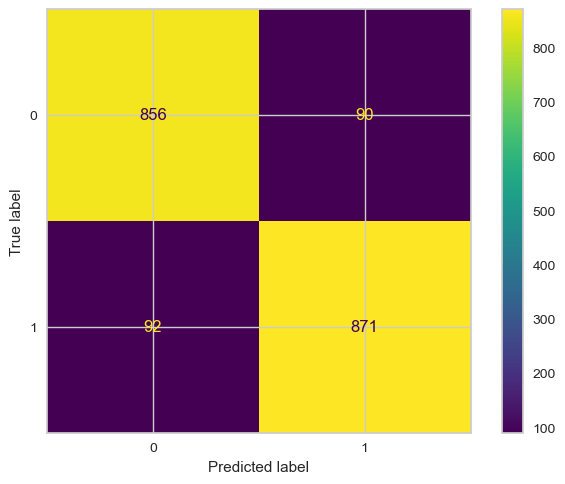

In [82]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp.plot();

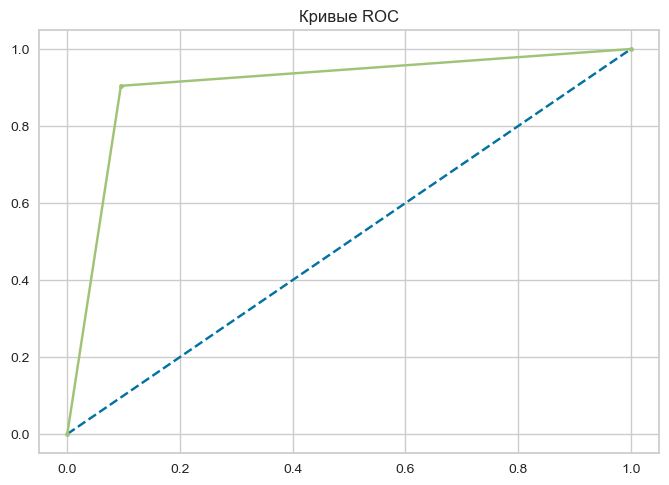

In [84]:
fpr, tpr, _ = roc_curve(y_test, y_pred_dt)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [85]:
# площадь под кривыми ROC-AUC
roc_dt = roc_auc_score(y_test, y_pred_dt); roc_dt.round(4)

0.9047

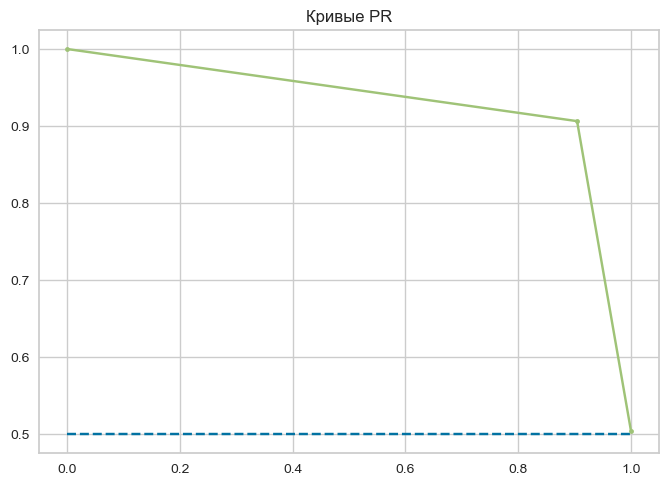

In [86]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_dt)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [87]:
# площадь под кривыми PR-AUC
pr_dt = auc(recall, precision); pr_dt.round(4)

0.9295

#### 7.6. Случайный лес

In [120]:
%%time
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

CPU times: total: 2.06 s
Wall time: 2.07 s


RandomForestClassifier()

In [121]:
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)

print(f'Accuracy score: {acc_rf.round(4)}')
print(f'F1 score: {f1_rf.round(4)}')
print(f'Precision score: {prec_rf.round(4)}')
print(f'Recall score: {rec_rf.round(4)}')

Accuracy score: 0.9502
F1 score: 0.9504
Precision score: 0.9559
Recall score: 0.945


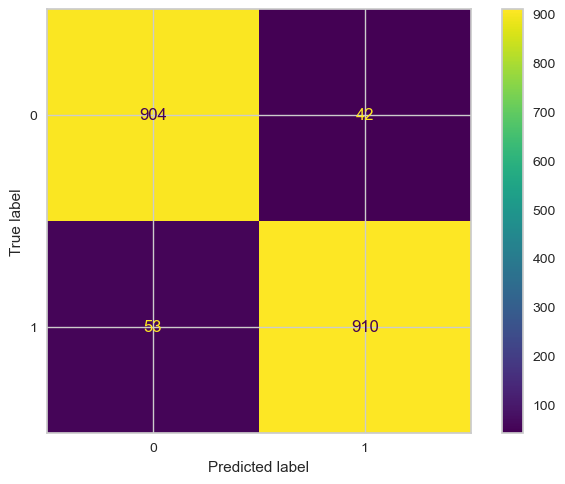

In [122]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp.plot();

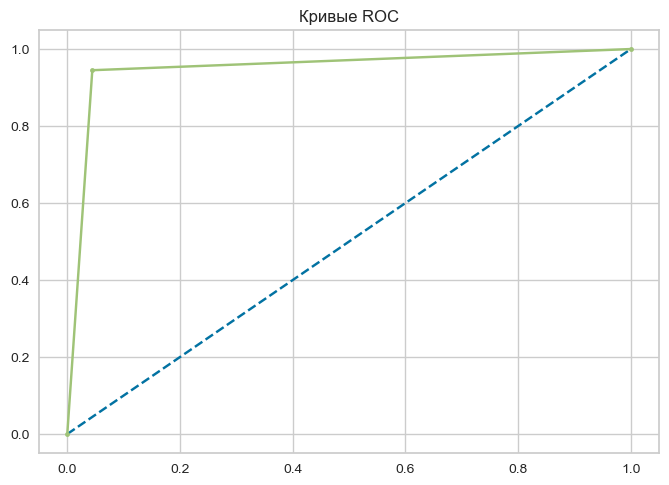

In [123]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [124]:
# площадь под кривыми ROC-AUC
roc_rf = roc_auc_score(y_test, y_pred_rf); roc_rf.round(4)

0.9503

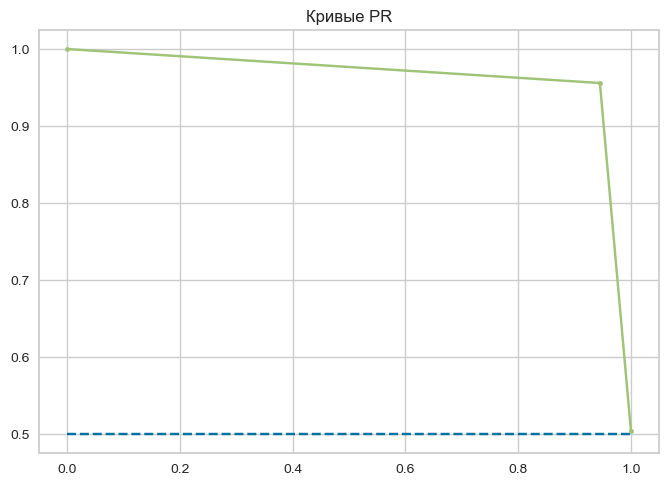

In [125]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_rf)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [126]:
# площадь под кривыми PR-AUC
pr_rf = auc(recall, precision); pr_rf.round(4)

0.9643

#### 7.7. Многослойный перцептрон

In [95]:
%%time
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

CPU times: total: 1.66 s
Wall time: 837 ms


MLPClassifier()

In [96]:
y_pred_mlp = mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)

print(f'Accuracy score: {acc_mlp.round(4)}')
print(f'F1 score: {f1_mlp.round(4)}')
print(f'Precision score: {prec_mlp.round(4)}')
print(f'Recall score: {rec_mlp.round(4)}')

Accuracy score: 0.539
F1 score: 0.176
Precision score: 0.8952
Recall score: 0.0976


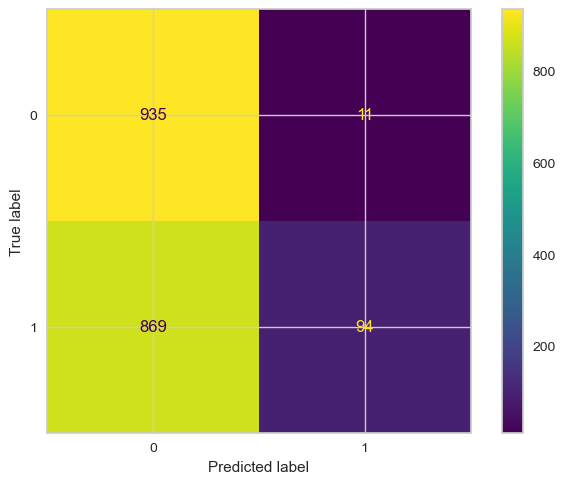

In [97]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=mlp.classes_)
disp.plot();

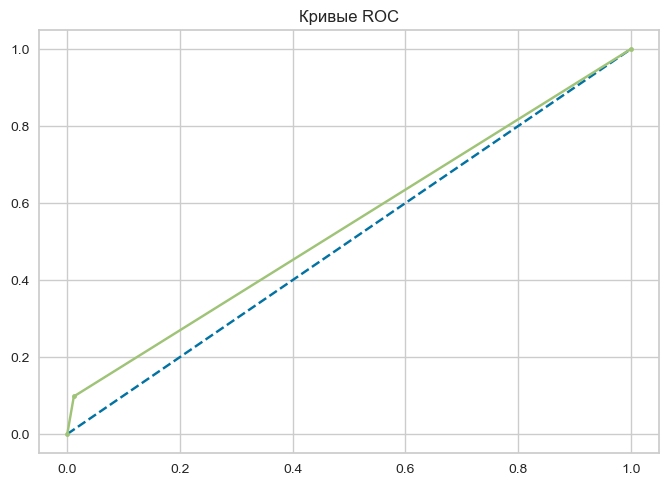

In [98]:
fpr, tpr, _ = roc_curve(y_test, y_pred_mlp)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

In [99]:
# площадь под кривыми ROC-AUC
roc_mlp = roc_auc_score(y_test, y_pred_mlp); roc_mlp.round(4)

0.543

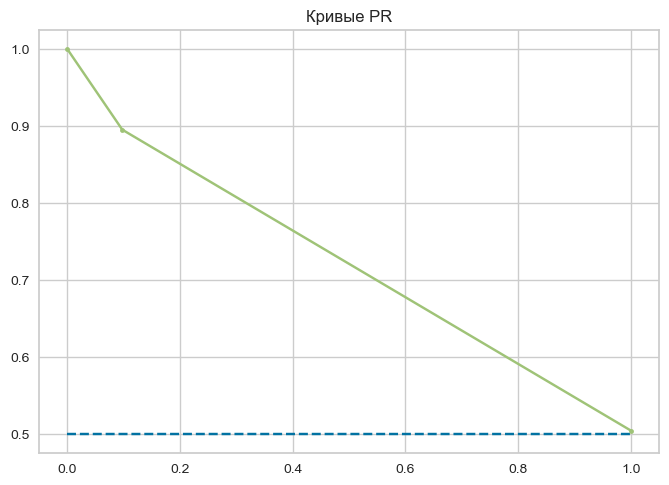

In [100]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_mlp)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

In [101]:
# площадь под кривыми PR-AUC
pr_mlp = auc(recall, precision); pr_mlp.round(4)

0.724

#### 7.8. Выводы

Для решения текущей задачи бинарной классификации было построено 10 различных моделей машинного обучения. В соответствии со значениями метрик, лучше всего справились модели Decision Tree и Random Forest, остальные модели показали менее высокие результаты. Дольше всего обучалась модель по методу опорных векторов с линейным ядром.

### 8. Выбрать наиболее перспективную модель для решения поставленной задачи. Изменить гиперпараметры модели. Предпочтительно, провести Grid Search. Найти оптимальные гиперпараметры.

In [102]:
names = ['Logistic Regression','KNN','SVM (linear)','SVM (rbf)','SVM (poly)','SVM (sigmoid)','Gaussian NB','Decision Tree',\
         'Random Forest','MLP']
column_names = ['Accuracy score','F1 score','Precision score','Recall score','ROC-AUC','PR-AUC']
results = pd.DataFrame(data=[[acc_lr.round(4),f1_lr.round(4),prec_lr.round(4),rec_lr.round(4),roc_lr.round(4),pr_lr.round(4)],\
                            [acc_knn.round(4),f1_knn.round(4),prec_knn.round(4),rec_knn.round(4),roc_knn.round(4),pr_knn.round(4)],\
                            [acc_lin.round(4),f1_lin.round(4),prec_lin.round(4),rec_lin.round(4),roc_lin.round(4),pr_lin.round(4)],\
                            [acc_rbf.round(4),f1_rbf.round(4),prec_rbf.round(4),rec_rbf.round(4),roc_rbf.round(4),pr_rbf.round(4)],\
                            [acc_poly.round(4),f1_poly.round(4),prec_poly.round(4),rec_poly.round(4),roc_poly.round(4),pr_poly.round(4)],\
                            [acc_sigmoid.round(4),f1_sigmoid.round(4),prec_sigmoid.round(4),rec_sigmoid.round(4),roc_sigmoid.round(4),pr_sigmoid.round(4)],\
                            [acc_nb.round(4),f1_nb.round(4),prec_nb.round(4),rec_nb.round(4),roc_nb.round(4),pr_nb.round(4)],\
                            [acc_dt.round(4),f1_dt.round(4),prec_dt.round(4),rec_dt.round(4),roc_dt.round(4),pr_dt.round(4)],\
                            [acc_rf.round(4),f1_rf.round(4),prec_rf.round(4),rec_rf.round(4),roc_rf.round(4),pr_rf.round(4)],\
                            [acc_mlp.round(4),f1_mlp.round(4),prec_mlp.round(4),rec_mlp.round(4),roc_mlp.round(4),pr_mlp.round(4)]], index=names, columns=column_names)
results

,Accuracy score,F1 score,Precision score,Recall score,ROC-AUC,PR-AUC
Logistic Regression,0.6579,0.6506,0.6711,0.6314,0.6582,0.7442
KNN,0.7454,0.7601,0.7244,0.7996,0.7449,0.8125
SVM (linear),0.7077,0.6921,0.7385,0.6511,0.7082,0.7828
SVM (rbf),0.5668,0.4795,0.6086,0.3956,0.5683,0.6546
SVM (poly),0.4955,0.6569,0.5000,0.9574,0.4914,0.7395
SVM (sigmoid),0.5107,0.5016,0.5159,0.4881,0.5109,0.6311
Gaussian NB,0.6941,0.6168,0.8378,0.4881,0.6959,0.7920
Decision Tree,0.9047,0.9054,0.9063,0.9045,0.9047,0.9295
Random Forest,0.9518,0.9520,0.9560,0.9481,0.9518,0.9651
MLP,0.5390,0.1760,0.8952,0.0976,0.5430,0.7240


Из всех моделей наивысшие показатели метрик Accuracy, F1, Precision, ROC-AUC и PR-AUC показала модель Случайного леса (Random Forest).

Случайный лес обладает следующими гиперпараметрами:
- Количество деревьев (n_estimators);
- Максимальная глубина деревьев (max_depth);
- Минимальное количество объектов в листе (min_samples_leaf);
- Максимальное количество признаков для разбиения (max_features).

Подберем оптимальные параметры с помощью Grid Search:

In [103]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Оптимальные гиперпараметры: {grid_search.best_params_}')
print(f'Лучший результат кросс-валидации: {grid_search.best_score_}')

Оптимальные гиперпараметры: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
Лучший результат кросс-валидации: 0.9451063040886583


После проведения Grid Search метрика точности не увеличилась.

### 9. С учетом сделанных выводов провести усовершенствование моделей. Это можно осуществить с помощью введения регуляризации, изменение параметров модели (для параметрических моделей), введением суррогатных признаков, отбором признаков, нормализацией данных, ансамблированием моделей, изменением алгоритма предварительной обработки данных. Сравнить результаты.

#### 9.1. Бустинг

Реализуем градиентный бустинг XGBoost. Это ансамблевая стратегия, которая включает в себя L1 и L2 регуляризацию. Это способствует предотвращению переобучения.

In [104]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softprob',
    'num_class': 3
}

bst = xgboost.train(params, dtrain, num_boost_round=100)

preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])

acc_xgb = accuracy_score(y_test, predictions)
f1_xgb = f1_score(y_test, predictions)
prec_xgb = precision_score(y_test, predictions)
rec_xgb = recall_score(y_test, predictions)

print(f'Accuracy score: {acc_xgb.round(4)}')
print(f'F1 score: {f1_xgb.round(4)}')
print(f'Precision score: {prec_xgb.round(4)}')
print(f'Recall score: {rec_xgb.round(4)}')

Accuracy score: 0.9125
F1 score: 0.9107
Precision score: 0.9383
Recall score: 0.8847


#### 9.2. Отбор признаков

Построим гистограмму важности признаков в модели Случайного леса:

DELINQ     0.198508
DEBTINC    0.156910
NINQ       0.104377
DEROG      0.103304
CLAGE      0.090587
MORTDUE    0.081782
LOAN       0.080895
CLNO       0.068264
YOJ        0.066812
JOB        0.026246
REASON     0.022315
dtype: float64


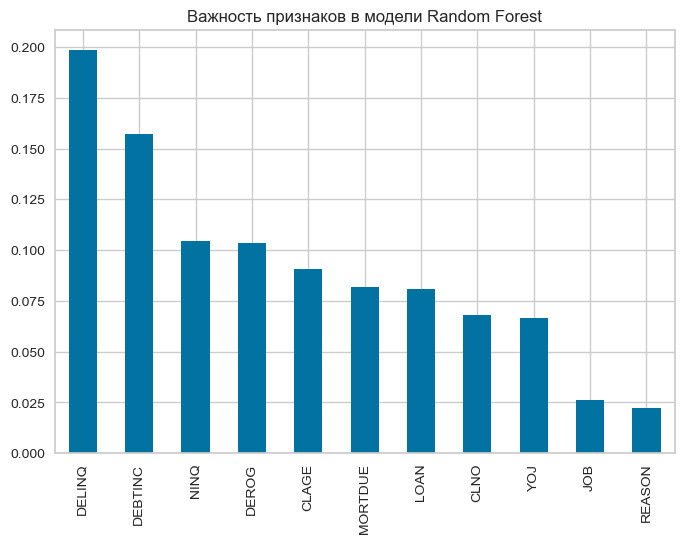

In [105]:
featimp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(featimp)
featimp.plot(kind='bar', title='Важность признаков в модели Random Forest');

Попробуем исключить признаки JOB и REASON:

In [106]:
X_sel = X.drop(['JOB', 'REASON'], axis=1)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y, test_size=0.2, random_state=42)

In [107]:
rf_sel = RandomForestClassifier(random_state=42)
rf_sel.fit(X_train_sel, y_train_sel)

RandomForestClassifier(random_state=42)

In [108]:
y_pred_rf_sel = rf_sel.predict(X_test_sel)

acc_rf_sel = accuracy_score(y_test_sel, y_pred_rf_sel)
f1_rf_sel = f1_score(y_test_sel, y_pred_rf_sel)
prec_rf_sel = precision_score(y_test_sel, y_pred_rf_sel)
rec_rf_sel = recall_score(y_test_sel, y_pred_rf_sel)

print(f'Accuracy score: {acc_rf_sel.round(4)}')
print(f'F1 score: {f1_rf_sel.round(4)}')
print(f'Precision score: {prec_rf_sel.round(4)}')
print(f'Recall score: {rec_rf_sel.round(4)}')

Accuracy score: 0.9455
F1 score: 0.9454
Precision score: 0.9564
Recall score: 0.9346


#### 9.3. Нормализация данных

In [109]:
X_norm  = (X - X.min()) / (X.max() - X.min ())
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=0.2, random_state=42)

Теперь признаки X_norm принимают значения от 0 до 1.

In [110]:
rf_norm = RandomForestClassifier(random_state=42)
rf_norm.fit(X_train_norm, y_train_norm)

RandomForestClassifier(random_state=42)

In [111]:
y_pred_rf_norm = rf_norm.predict(X_test_norm)

acc_rf_norm = accuracy_score(y_test_norm, y_pred_rf_norm)
f1_rf_norm = f1_score(y_test_norm, y_pred_rf_norm)
prec_rf_norm = precision_score(y_test_norm, y_pred_rf_norm)
rec_rf_norm = recall_score(y_test_norm, y_pred_rf_norm)

print(f'Accuracy score: {acc_rf_norm.round(4)}')
print(f'F1 score: {f1_rf_norm.round(4)}')
print(f'Precision score: {prec_rf_norm.round(4)}')
print(f'Recall score: {rec_rf_norm.round(4)}')

Accuracy score: 0.9466
F1 score: 0.9466
Precision score: 0.9546
Recall score: 0.9387


#### 9.4. Сравнение результатов

In [112]:
names = ['Градиентный бустинг','Отбор признаков','Нормализация данных']
column_names = ['Accuracy score','F1 score','Precision score','Recall score']
results = pd.DataFrame(data=[[acc_xgb.round(4),f1_xgb.round(4),f1_xgb.round(4),rec_xgb.round(4)],\
                             [acc_rf_sel.round(4),f1_rf_sel.round(4),f1_rf_sel.round(4),rec_rf_sel.round(4)],\
                             [acc_rf_norm.round(4),f1_rf_norm.round(4),f1_rf_norm.round(4),rec_rf_norm.round(4)]], index=names, columns=column_names)
results

,Accuracy score,F1 score,Precision score,Recall score
Градиентный бустинг,0.9125,0.9107,0.9107,0.8847
Отбор признаков,0.9455,0.9454,0.9454,0.9346
Нормализация данных,0.9466,0.9466,0.9466,0.9387


### 10. Представить результаты моделирования в наглядном виде (графики, линии обучения, таблицы сравнения моделей, таблицы классификации, и другие). Сделать выводы, сравнить с существующими аналогичными решениями, порассуждать о перспективах решения проблемы.

По результатам сравнения метрик Accuracy score, F1 score, Precision score, Recall score, а также площадей под кривыми ROC и PR, была выбрана модель Случайного леса (Random Forest):

In [113]:
results

,Accuracy score,F1 score,Precision score,Recall score
Градиентный бустинг,0.9125,0.9107,0.9107,0.8847
Отбор признаков,0.9455,0.9454,0.9454,0.9346
Нормализация данных,0.9466,0.9466,0.9466,0.9387


Подбор оптимальных гиперпараметров методом Grid Search, отбор признаков и нормализация данных в данном случае не повысили показатели метрик.

Результаты кросс-валидации:

In [127]:
kf = KFold(n_splits=5, shuffle=True)
rf_ = RandomForestClassifier()

In [128]:
cv_results = cross_val_score(rf_,
                             X,
                             y,
                             cv = kf,
                             scoring = 'accuracy',
                             n_jobs=-1)

print('Кросс-валидация: ', cv_results)
print('Среднее по кросс-валидации: ', cv_results.mean())
print('Дисперсия по кросс-валидации: ', cv_results.std())

Кросс-валидация:  [0.94814039 0.95128339 0.94549266 0.94916143 0.95754717]
Среднее по кросс-валидации:  0.9503250079892993
Дисперсия по кросс-валидации:  0.0040634020052281936


Еще раз выведем на экран матрицу классификации и графики кривых ROC и PR:

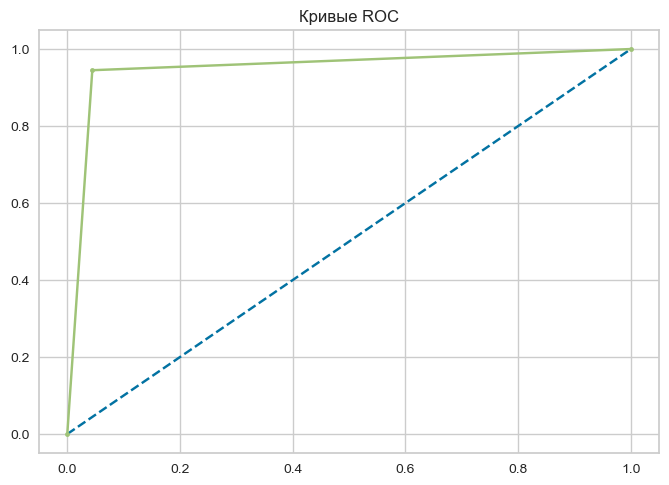

In [129]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Кривые ROC')
plt.show()

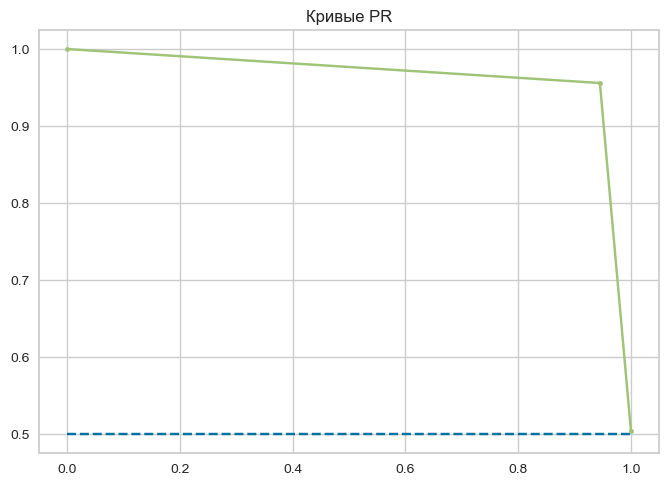

In [130]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_rf)
no_skill = len(y[y==1])/len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Кривые PR')
plt.show()

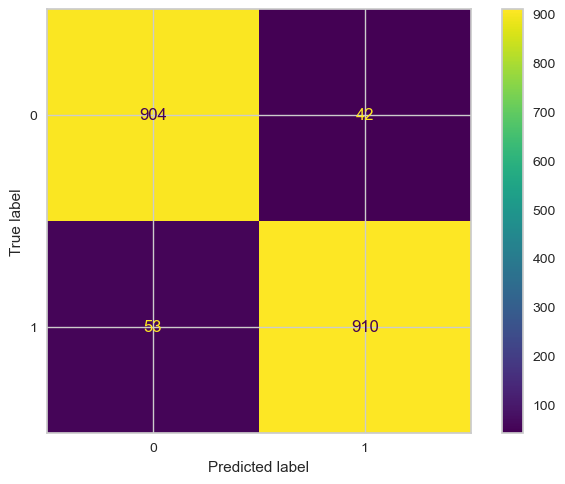

In [131]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot();

Построим кривые обучения:

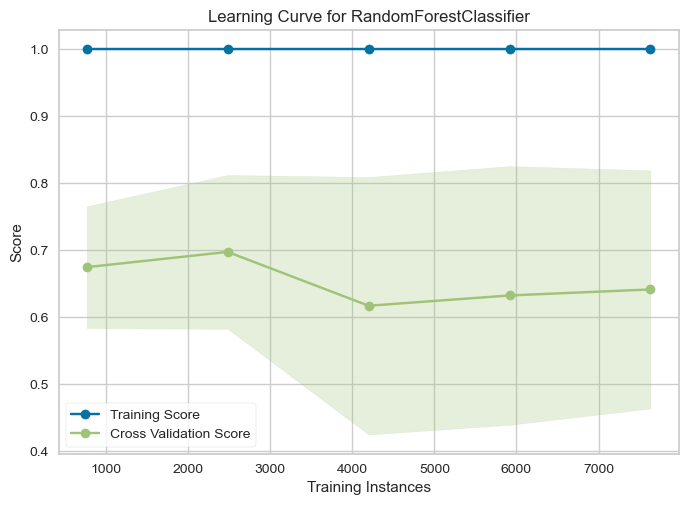

In [133]:
visualizer = LearningCurve(
    RandomForestClassifier(),
).fit(X, y).show() 

В данной работе было показано применение различных моделей машинного обучения в задаче создания алгоритма кредитного скоринга. Кредитование является одной из самых распространенных услуг, предоставляемых банками, а внедрение алгоритмов машинного обучения помогает банковским учреждениям снизить риски. Кроме того, автоматизация процесса выдачи кредита позволяет клиентам получить кредит проще и быстрее. В настоящее время в международном сообществе стоит задача построения единой системы автоматизированного кредитного скоринга, основанной одновременно на нескольких моделях, что будет обеспечивать высокие прогнозные способности этой системы.

В процессе работы были задействованы различные алгоритмы машинного обучения, такие как Логистическая регрессия, Метод K-ближайших соседей, Метод опорных векторов, Наивный Байесовский классификатор, Дерево решений, Случайный лес и Многослойный перцептрон. В рамках текущей задачи метрики Accuracy, F1, Precision, ROC-AUC и PR-AUC оказались выше у модели случайного леса Random Forest. Подбор оптимальных гиперпараметров методом Grid Search, отбор признаков и нормализация данных практически не изменили метрики.